<a href="https://colab.research.google.com/github/michael-rowland/Pitch-Predictions/blob/master/Pitch-Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NOTES

---

QUESTIONS: 
- should I keep notes in docstring?
- stance mapping 0/1
- should I drop columns? When?

Features:
- Shifting?
- Home/Away

Per pitcher models

Exponential Smoothing

Permutation Importances

AVERAGE ROC AUC / SCORECARD

MULTIPLE PITCHERS

MODEL TYPES



## SETUP

---



In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install pybaseball

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
# import os
# import numpy as np
import pandas as pd
import category_encoders as ce
from pybaseball import statcast_pitcher, playerid_lookup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## DATA GATHERING

---


For now I am just going to focus on pitchers from my favorite team, the Minnesota Twins. 

Pitchers I will use will come from [here](https://theathletic.com/1570769/2020/01/30/twins-roster-projection-4-0-welcome-bringer-of-rain-and-human-bazooka/), plus recent trade acquisition, Kenta Maeda.

Additional development: grow out dataset to players with X number of innings pitched

In [3]:
berrios_id = playerid_lookup('berrios', 'jose').loc[0, 'key_mlbam']

Gathering player lookup table. This may take a moment.


In [4]:
berrios = statcast_pitcher('2008-04-01', '2020-01-01', berrios_id)

Gathering Player Data


## DATA CLEANING

---



In [5]:
def reorder(df):
  '''
  reorders pitches in ascending order
  '''
  df = df.copy()

  df = df.reindex(index=df.index[::-1])
  df = df.reset_index(drop=True)

  return df

In [6]:
def pitch_cleaning(df):
  '''
  cleans target ('pitch_type'), dropping NaN's (bad data) and non-standard 
  pitches
  '''
  df = df.copy()

  df = df.dropna(subset=['pitch_type'])
  
  df['pitch_type'] = df['pitch_type'].str.lower()
  remove_pitches = ['po', 'in', 'un']
  df = df[~df['pitch_type'].isin(remove_pitches)]
#   df = df.drop('pitch_name', axis=1)

  return df

In [7]:
def historical_cleaning(df):
  '''
  shifts relevant historical data to prevent data leakage
  '''
  df = df.copy()

  df['previous_pitch'] = df['pitch_type'].shift(1)
  df['previous_strike'] = df['type'].shift(1) == 'S'
  df['previous_zone'] = df['zone'].shift(1) # this may need to be encoded somehow
  df = df.drop(['type', 'zone'], axis=1)
  fill_na = ['previous_pitch', 'previous_zone']
  df[fill_na] = df[fill_na].fillna(0)

  return df

## DATA PROCESSING

---


In [8]:
def total_pitches(df):
  '''
  creates column of total pitches prior to current/target pitch
  '''
  df = df.copy()

  df['pitch_total'] = df.groupby('game_date').cumcount(ascending=True)

  return df

In [9]:
def score_margin(df):
  '''
  creates column of score margin for the pitcher's team
  '''
  df = df.copy()

  df['score_margin'] = df['fld_score'] - df['bat_score']
  df = df.drop(['fld_score', 'bat_score'], axis=1)

  return df

In [10]:
def pitcher_advantage(df):
  '''
  creates column of pitcher advantage based on the ball/strike count
  '''
  df = df.copy()

  advantages = {'0-0':'neutral', '0-1':'ahead', '0-2':'ahead', '1-0':'neutral', 
                '1-1':'neutral', '1-2':'ahead', '2-0':'behind', '2-1':'neutral',
                '2-2':'ahead', '3-0':'behind', '3-1':'behind', '3-2':'neutral'}

  df['count'] = df['balls'].astype(str) + '-' + df['strikes'].astype(str)
  df['pitcher_advantage'] = df['count'].map(advantages)
  df = df.drop('count', axis=1)

  return df

In [11]:
def baserunners_mapping(df):
  '''
  maps baserunner to boolean values and creates column if there is a baserunner 
  on any base
  '''
  df = df.copy()

  df['on_1b'] = df['on_1b'].notnull()
  df['on_2b'] = df['on_2b'].notnull()
  df['on_3b'] = df['on_3b'].notnull()
  
  df['baserunner'] = df['on_1b'] | df['on_2b'] | df['on_3b']

  return df

In [12]:
def at_bat_counter(df):
  '''
  creates column of number of batters faced
  '''
  df = df.copy()

  df['at_bat_count'] = df.groupby('at_bat_number').ngroup(ascending=True)+1
  df = df.drop('at_bat_number', axis=1)

  return df

In [13]:
def pitch_encoding(df):
  '''
  creates columns of previous pitch for each pitch type using OneHotEncoder
  '''
  df = df.copy()

  encoder = ce.OneHotEncoder(use_cat_names=True)
  encoded = encoder.fit_transform(df['previous_pitch'])
  df = pd.merge(df, encoded, how='outer', on=df.index)
  df = df.drop(['key_0', 'previous_pitch_0'], axis=1)
  
  return df

In [14]:
def pitch_counter(df):
  '''
  creates columuns of cumulative count of each specific pitch type
  '''
  df = df.copy()

  pitches = [col for col in df if col.startswith('previous_pitch_')]
  
  for pitch in pitches:
    df[f'count_{pitch[-2:]}'] = (df[pitch] == 1).cumsum()

  return df

In [15]:
def pitch_tendency(df, window):
  '''
  creates columns of pitch tendency (mean) over last n = window pitches for 
  each pitch type
  '''
  df = df.copy()

  pitches = [col for col in df if col.startswith('previous_pitch_')]
  
  for pitch in pitches:
#     df[f'{pitch[-2:]}_tendency_{window}'] = df[pitch].iloc[1:].rolling(
    df[f'{pitch[-2:]}_tendency_{window}'] = df[pitch].rolling(
        window, min_periods=1).mean()
    
  return df

In [16]:
def strike_encoding(df):
  '''
  creates columns of strike pitch for each pitch type using OneHotEncoder
  '''
  df = df.copy()
  
  s = df['previous_strike'] == True
  df['strike_pitch'] = s.mask(s, df['previous_pitch'])
  
  encoder = ce.OneHotEncoder(use_cat_names=True)
  encoded = encoder.fit_transform(df['strike_pitch'])
  df = pd.merge(df, encoded, how='outer', on=df.index)
  df = df.drop(['key_0', 'strike_pitch_False', 'strike_pitch'], 
               axis=1, errors='ignore')
  
  return df

  * This could be further engineered to calculate percentage of total number of 
  strikes thrown rather than number of total pitches


In [17]:
def strike_percentage(df, percentage=True):
  '''
  creates columns of strike percentage (or raw count) for each pitch type
  '''
  df = df.copy()

  pitches = [col for col in df if col.startswith('strike_pitch_')]

  for i in pitches:
    target = f'{i[-2:]}_cumulative_strikes'
    if percentage:
      df[target] = (df[f'strike_pitch_{i[-2:]}'] == 1).cumsum() / df['pitch_total']
    else:
      df[target] = (df[f'strike_pitch_{i[-2:]}'] == 1).cumsum()
    df[target] = df[target].fillna(0)
      
  return df

In [18]:
def strike_counter(df, window):
  '''
  creates columns of number of previous n (window) strikes thrown for each pitch 
  type
  '''
  df = df.copy()
  
  pitches = [col for col in df if col.startswith('strike_pitch_')]
  
  for i in pitches:
    target = f'{i[-2:]}_strike_tendency_{window}'
    df[target] = df[df[i] != 0][i].rolling(window, min_periods=1).sum()
    df[target] = df[target].fillna(method='ffill')
    df[target] = df[target].fillna(0)

  return df

In [19]:
def wrangle_game(df):
  '''
  this function does data cleaning and feature engineering on a per game basis
  '''
  df = df.copy()

  # CLEANING FUNCTIONS
  df = reorder(df)
  df = pitch_cleaning(df)
  if df.empty:
    return
  df = historical_cleaning(df)

  # FEATURE ENGINEERING FUNCTIONS
  df = total_pitches(df)
  df = score_margin(df)
  df = pitcher_advantage(df)
  df = baserunners_mapping(df)
  df = at_bat_counter(df)
  df = pitch_encoding(df)
  df = pitch_counter(df)
  
  windows = [5, 10, 20]
  for window in windows:
    df = pitch_tendency(df, window) 
  df = strike_encoding(df)
  df = strike_percentage(df, percentage=True)
  for window in windows:
    df = strike_counter(df, window)
  
  return df

In [20]:
def pitcher_wrangle(pitcher_data):
  '''
  wrangles all available data on specific pitcher (prior to 2020 season)
  '''
  
#   THIS HAS TO BE IN HERE, AND I'M NOT SURE WHY
  # target = 'pitch_type'
  features = ['pitch_name', 'pitch_type', 'game_date', 'stand', 'balls', 
              'strikes', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 
              'at_bat_number', 'bat_score', 'fld_score', 'type', 'zone', 
              'player_name']
  
  # raw_data = statcast_pitcher('2008-04-01', '2020-01-01', pitcher)

  df = pd.DataFrame()

  games = pitcher_data['game_date'].unique().tolist()
  
  for game in games:
    game_data = wrangle_game(pitcher_data[pitcher_data['game_date'] == game][features])
    # game_data = wrangle_game(pitcher_data[pitcher_data['game_date'] == game])
    df = df.append(game_data, ignore_index=True, sort=False)
    
  return df

In [21]:
df = pitcher_wrangle(berrios)

In [22]:
df = df.drop(['pitch_name', 'player_name'], axis=1)

In [23]:
import matplotlib.pyplot as plt

In [24]:
df['game_date'] = pd.to_datetime(df['game_date'])
df['year'] = df['game_date'].dt.year
df['month'] = df['game_date'].dt.month

In [25]:
tendencies = df.groupby(['year', 'month']).mean()
pitches = tendencies.columns.str.startswith('previous_pitch_')
plot_data = tendencies.loc[:, pitches]
plot_data.columns = ['Fastball', 'Two-Seam', 'Curveball', 'Changeup']

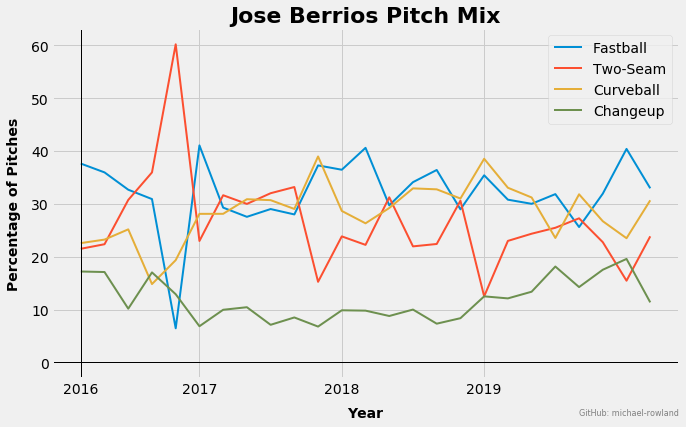

In [162]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(10, 6))

for pitch in plot_data.columns:
  plt.plot(range(len(plot_data)), plot_data[pitch], 
           label=pitch, linewidth=2)

ax.legend()

ax.set_title('Jose Berrios Pitch Mix', fontsize=22, fontweight='bold')
ax.set_xlabel('Year', 
              fontsize=14, fontweight='bold', labelpad=10)
ax.set_ylabel('Percentage of Pitches', 
              fontsize=14, fontweight='bold', labelpad=10)

ax.set_xticks([0, 5, 11, 17])
ax.set_xticklabels(range(2016, 2020))
ax.set_yticklabels(range(-10,70,10))

ax.axhline(y=0, color='black', linewidth=1)
ax.axvline(x=0, color='black', linewidth=1)
ax.text(x=21, y=-0.1, s='GitHub: michael-rowland', fontsize=8, color='grey')
plt.savefig('Pitch-Mix.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


In [45]:
mix = df[df['game_date'].dt.year == 2019]['pitch_type'].value_counts()
mix = mix.rename_axis('pitch_type').reset_index(name='counts')

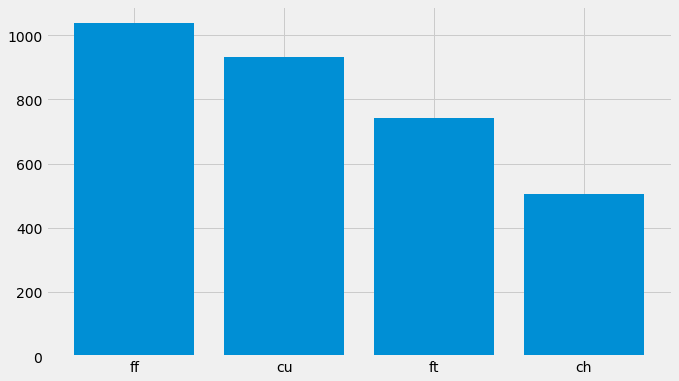

In [46]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(mix['pitch_type'], mix['counts'])
plt.show()

## MODEL

---



In [47]:
# MOVE TO TOP WHEN FINISHED
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

In [48]:
def log_model(txt_file='model_log.txt'):
    with open(txt_file, 'a') as file:
        file.write(f'Validation accuracy: {model.score(X_val_processed, y_val):.5f}\n')
        file.write(f'Features: {X_train.columns}\n')
        file.write(f'{model.get_params}\n')
        file.write('\n')
        file.close()

In [49]:
train, test = train_test_split(df, train_size=0.8, random_state=42)
train, val = train_test_split(train, train_size=0.8, random_state=42)

In [50]:
target = 'pitch_type'
features = df.columns.drop([target, 'game_date'])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [53]:
processor = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean')
)
X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)
X_test_processed = processor.transform(X_test)

model = RandomForestClassifier(
                               n_estimators=100, 
                               max_features=16,
                               max_depth=9, 
                               random_state=42, 
                               n_jobs=-1)
model.fit(X_train_processed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features=16,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [55]:
baseline = df['pitch_type'].value_counts(normalize=True)
print(f'Baseline Accuracy: {baseline[0]:.5f}')
print(f'Train Accuracy: {model.score(X_train_processed, y_train):.5f}')
print(f'Validation Accuracy: {model.score(X_val_processed, y_val):.5f}')
print(f'Test Accuracy: {model.score(X_test_processed, y_test):.5f}')

Baseline Accuracy: 0.32516
Train Accuracy: 0.66007
Validation Accuracy: 0.42629
Test Accuracy: 0.41858


In [164]:
predictions_df = pd.DataFrame({'True Values': y_val,
                            'Predictions': model.predict(X_val_processed)})
predictions_df = predictions_df.apply(lambda x: x.value_counts())

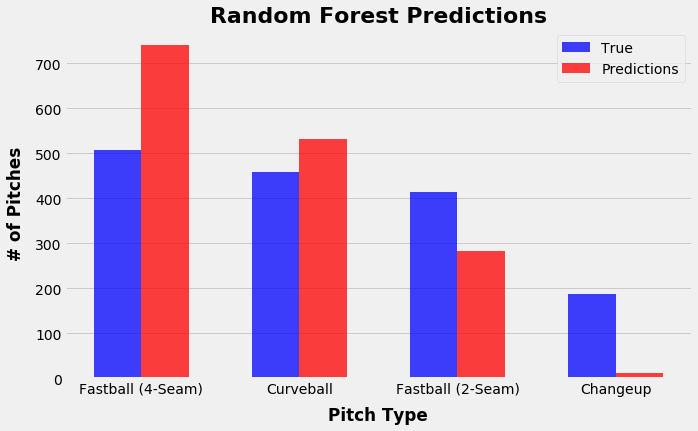

In [167]:
import numpy as np
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(10, 6))

X = np.arange(len(predictions_df['Predictions'].unique()))
bar_width = 0.30

ax.bar(X - bar_width/2, predictions['True Values'], 
       color = 'b', width = bar_width, align='center', alpha=0.75, label='True')
ax.bar(X + bar_width/2, predictions['Predictions'], 
       color = 'r', width = bar_width, align='center', alpha=0.75, label='Predictions')

ax.legend()

ax.set_xticks(X)
ax.set_xticklabels(['Fastball (4-Seam)', 'Curveball', 'Fastball (2-Seam)', 'Changeup'])

ax.set_title('Random Forest Predictions', fontsize=22, fontweight='bold')
ax.set_xlabel('Pitch Type', fontweight='bold', labelpad=10)
ax.set_ylabel('# of Pitches', fontweight='bold', labelpad=10)
ax.xaxis.grid(False)

plt.savefig('Predictions.png', format='png', dpi=300, bbox_inches='tight')
plt.show()



---




In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import f_regression, SelectKBest
from scipy.stats import randint, uniform

target = 'pitch_type'
features = df.columns.drop([target, 'game_date'])
train, test = train_test_split(df, train_size=0.8, random_state=0)
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
#     SelectKBest(f_regression), 
    RandomForestClassifier()
)

param_distributions = {
  'simpleimputer__strategy': ['mean', 'median'], 
#   'selectkbest__k': range(1, len(X_train.columns)+1), 
#   'randomforestclassifier__n_estimators': randint(100, 200), 
  'randomforestclassifier__max_features': range(1, 26), 
  'randomforestclassifier__max_features': uniform(0, 1), 
  'randomforestclassifier__max_depth': [5, 8, 9, 10, 11, 12, 15, 20, None], 
  'randomforestclassifier__min_samples_split': range(2, 11), 
}

search = RandomizedSearchCV(
  pipeline, 
  param_distributions=param_distributions, 
  n_iter=10, 
  cv=5, 
  scoring='accuracy', 
  verbose=10, 
  return_train_score=True, 
  n_jobs=-1
)

In [123]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.2s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [124]:
search.best_params_

{'randomforestclassifier__max_depth': 5,
 'randomforestclassifier__max_features': 0.6100121664782999,
 'randomforestclassifier__min_samples_split': 3,
 'simpleimputer__strategy': 'mean'}

In [125]:
search.best_score_

1.0

## LOGISTIC REGRESSION

In [ ]:
log_df = df
pitch_mapping = {'ff': 1, 'ft': 1, 'cu': 0, 'ch': 0}
log_df['pitch_type'] = log_df['pitch_type'].map(pitch_mapping)

advantage_mapping = {'behind': -1, 'neutral': 0, 'ahead': 1}
log_df['pitcher_advantage'] = log_df['pitcher_advantage'].map(advantage_mapping)

stance_mapping = {'L': 1, 'R': 0}
log_df['stand'] = log_df['stand'].map(stance_mapping)

bool_cols = ['on_3b', 'on_2b', 'on_1b', 'previous_strike', 'baserunner']
log_df[bool_cols] = log_df[bool_cols].astype(int)

drop_cols = ['game_date', 'player_name', 'previous_zone', 'previous_pitch', 'pitch_name']
# drop_cols = ['player_name', 'previous_zone', 'previous_pitch', 'pitch_name']
log_df = log_df.drop(drop_cols, axis=1)

for column in log_df.columns:
  isnull = log_df[column].isnull().any()
  if isnull:
    log_df[column] = log_df[column].fillna(0)

In [100]:
baseline = log_df['pitch_type'].value_counts(normalize=True).tolist()[0]
baseline

0.59375

In [ ]:
target = 'pitch_type'
features = log_df.columns.drop(target)

train, test = train_test_split(log_df, train_size=0.8, random_state=42)
train, val = train_test_split(train, train_size=0.8, random_state=42)

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [107]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

lr = LogisticRegression()
lr.fit(X_train, y_train)
accuracy = lr.score(X_val, y_val)
print(f'Validation Accuracy: {accuracy*100:.2f}%')

Validation Accuracy: 60.63%


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
err = log_df[(log_df['game_date'] == '2019-05-13')]
err[err['previous_pitch_ch'] == 1].T

In [ ]:
import matplotlib.pyplot as plt

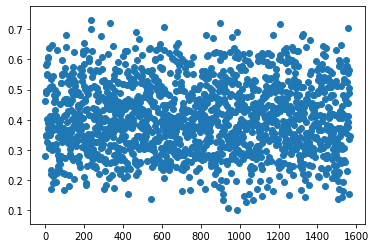

In [121]:
probabilities = lr.predict_proba(X_val)

plt.scatter(range(len(probabilities)), probabilities[:,0])
plt.show()

## MISC

---



In [ ]:
def pitch_map(df):
  '''
  generates dictionary mapping 'pitch_type' to 'pitch_name'
  '''
  df = df.copy()

  df = df.dropna(subset=['pitch_type', 'pitch_name'])
  pitch_types = df['pitch_name'].unique().tolist()
  pitch_types_abv = [i.lower() for i in df['pitch_type'].unique().tolist()]
  
  return dict(zip(pitch_types_abv, pitch_types))

# sample = 'https://raw.githubusercontent.com/michael-rowland/Pitch-Predictions/master/sample.csv'
# df = pd.read_csv(sample)
# df = df[df['game_date'] == '2018-09-28']

In [ ]:
# import time

# twins_pitchers = [
#   ['jose', 'berrios'], 
#   ['jake', 'odorizzi'], 
#   ['homer', 'bailey'], 
#   ['lewis', 'thorpe'], 
#   ['randy', 'dobnak'], 
#   ['kenta', 'maeda'], 
#   ['taylor', 'rogers'], 
#   ['sergio', 'romo'], 
#   ['tyler', 'duffey'], 
#   ['trevor', 'may'], 
#   ['tyler', 'clippard'], 
#   ['zack', 'littell'], 
#   ['matt', 'wisler']
# ]

# for pitcher in twins_pitchers[5:6]:
#   print(f'{pitcher[0]} {pitcher[1]}')
#   start = time.time()
#   lookup = playerid_lookup(pitcher[1], pitcher[0])
#   pitcher_id = lookup.loc[0, 'key_mlbam']
#   pitcher.append(pitcher_id)
#   df = pitcher_wrangle(pitcher_id)
#   pitcher.append(df)
#   end = time.time()
#   print(f'Time: {end - start}')
#   print(lookup)